<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

_By Jeff Hale - some adapted from Mahdi S_

# Time Series Forecasting Intro 🗓

## Learning Objectives
By the end of the lesson you will:

- Know how to approach a time series forecasting problem.
- Be able to make several baseline time series models.
- Make exponential smoothing models including Holt-Winters.

---

#### Prior knoweldge required
- Python, pandas, and machine learning basics
- Time series basics

---


## Common types of time series forecasting problems

- Forecast a single value of the time series. (use y historic values of y to predict y at one point in the future)
- Forecast a whole range of future values. (use historic values of y to predict y at many points in the future)
- Use other features to aid in your forecast. (predict many y in the future and use y and X)
- Forecast multiple time series simultaneously

## Approaching time series forecasting problems

## Before modeling
- Get the time period into *datetime* dtype format
- put it in the index
- sort the index

## Modeling considerations
- Make sure you are clear what you are predicting (one value, a range of values, one-step-ahead that updates every time period?)
- **Make sure you aren't leaking information from the future into your training data**
- Make null baseline models

## Example: Store sales data from Walmart

### Let's forecast one single value one time period into the future

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Prepare data

#### Read in the dataset, set the index as a datetime index, sort it, and take a look at it.

In [3]:
data = pd.read_csv('data/train.csv', parse_dates = ['Date'], index_col='Date')
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


In [4]:
data.index

DatetimeIndex(['2010-02-05', '2010-02-12', '2010-02-19', '2010-02-26',
               '2010-03-05', '2010-03-12', '2010-03-19', '2010-03-26',
               '2010-04-02', '2010-04-09',
               ...
               '2012-08-24', '2012-08-31', '2012-09-07', '2012-09-14',
               '2012-09-21', '2012-09-28', '2012-10-05', '2012-10-12',
               '2012-10-19', '2012-10-26'],
              dtype='datetime64[ns]', name='Date', length=421570, freq=None)

In [6]:
data.sort_index(inplace=True)

#### Rename sales column

In [7]:
data.rename(columns = {'Weekly_Sales': 'sales'}, inplace=True)

In [8]:
data.head(2)

,Store,Dept,sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-05,29,5,15552.08,False


#### Filter the DataFrame to Store 1 weekly sales only

In [9]:
store_1_data = data[data['Store'] ==1].copy()
store_1_data.head()

,Store,Dept,sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-05,1,49,11501.46,False
2010-02-05,1,48,814.00,False
2010-02-05,1,47,70.00,False
2010-02-05,1,51,1.16,False


In [10]:
store_1_data.tail(3)

,Store,Dept,sales,IsHoliday
Date,,,,
2012-10-26,1,34,9972.00,False
2012-10-26,1,33,6313.48,False
2012-10-26,1,35,1459.47,False


Aggregate all departments to compute the total sales per store. Keep only that column.

Each department is in its own row, so you can aggregate sales by date.

In [11]:
store_1_sales = store_1_data.groupby(store_1_data.index)[['sales']].sum()
store_1_sales.head(3)

,sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17


#### Plot it

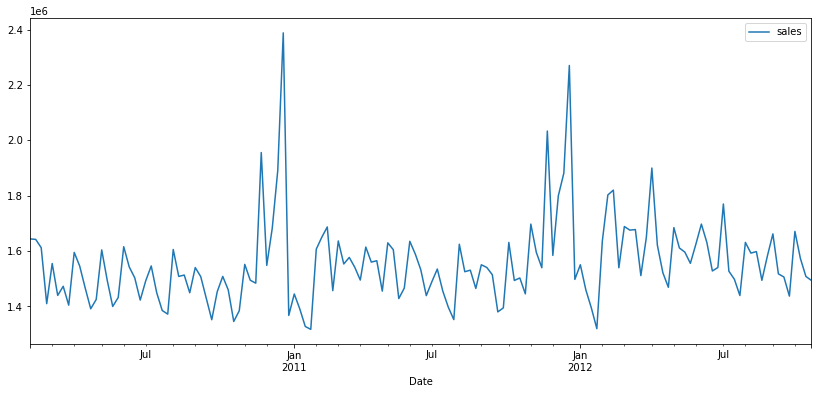

In [12]:
store_1_sales.plot(figsize=(14,6));

### Split the dataset into train and test sets.

Subset the data to train and test. **The test set must come after the training set.** Why?

#### Let's make the two datasets manually

In [13]:
train = store_1_sales.loc[:'2012-1']
train.head(3)

,sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17


In [14]:
train.tail(2)

,sales
Date,
2012-01-20,1394393.84
2012-01-27,1319325.59


In [15]:
test = store_1_sales.loc['2012-2':]

In [16]:
test.head(2)

,sales
Date,
2012-02-03,1636339.65
2012-02-10,1802477.43


In [18]:
test.tail(2)

,sales
Date,
2012-10-19,1508068.77
2012-10-26,1493659.74


In [19]:
test.shape

(39, 1)

Plot the two DataFrames

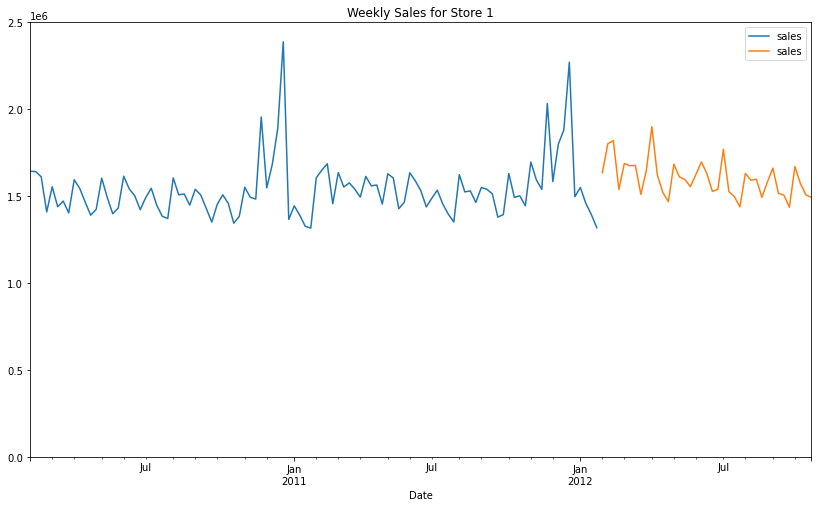

In [22]:
train['sales'].plot()
test['sales'].plot(figsize = (14,8), title = 'Weekly Sales for Store 1')
plt.legend()
plt.ylim(0, 2.5E6);

## Model 1: Naive Forecast

Take the last time period's sales and estimate the same value for all future time periods. This method is a **naive forecast**.

$${\Large \hat y_{t+1} = y_t}$$

Make a predictions DataFrame and set the predicted values equal to the last value in the `Sales` df.

In [23]:
train.tail(1)

,sales
Date,
2012-01-27,1319325.59


#### Save our results in a *df_predictions* DataFrame.

In [24]:
df_predictions = test.copy()

In [25]:
df_predictions.head(3)

,sales
Date,
2012-02-03,1636339.65
2012-02-10,1802477.43
2012-02-17,1819870.00


#### Take the last training dataset value and make that the guess for all future time periods.

In [27]:
df_predictions['last'] = train['sales'].iloc[-1]
df_predictions.head()

,sales,last
Date,,
2012-02-03,1636339.65,1319325.59
2012-02-10,1802477.43,1319325.59
2012-02-17,1819870.00,1319325.59
2012-02-24,1539387.83,1319325.59
2012-03-02,1688420.76,1319325.59


#### Plot the historic data, the actual "future" data, and the predicted "future" data.

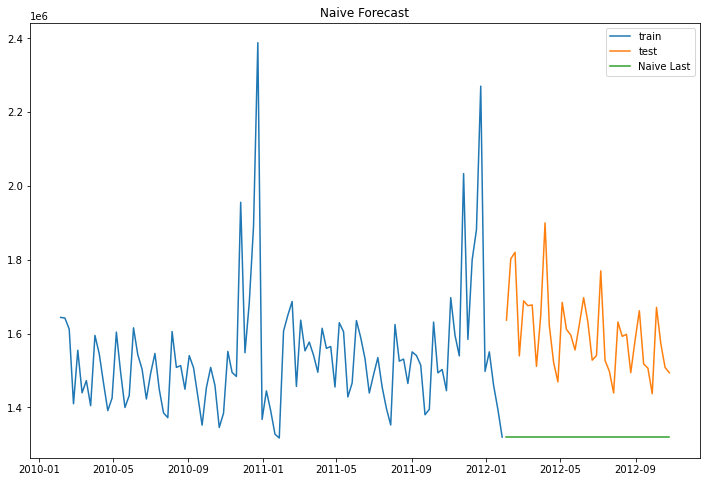

In [28]:
plt.figure(figsize=(12,8))

plt.plot(train['sales'], label = 'train')
plt.plot(test['sales'], label = 'test')
plt.plot(df_predictions['last'], label = 'Naive Last')

plt.legend()
plt.title('Naive Forecast');

#### Score our model
On RMSE.

In [30]:
from sklearn.metrics import mean_squared_error

In [31]:
mean_squared_error(df_predictions['sales'], df_predictions['last'], squared=False)

301180.15880211594

#### That's the most basic baseline.


---
## Model 2: Simple average of the training data
Another baseline model. Maybe slightly better when the data don't have much of a trend.

In [32]:
df_predictions['simple_mean'] = train['sales'].mean()
df_predictions.head(3)

,sales,last,simple_mean
Date,,,
2012-02-03,1636339.65,1319325.59,1.537735e+06
2012-02-10,1802477.43,1319325.59,1.537735e+06
2012-02-17,1819870.00,1319325.59,1.537735e+06


#### Plot

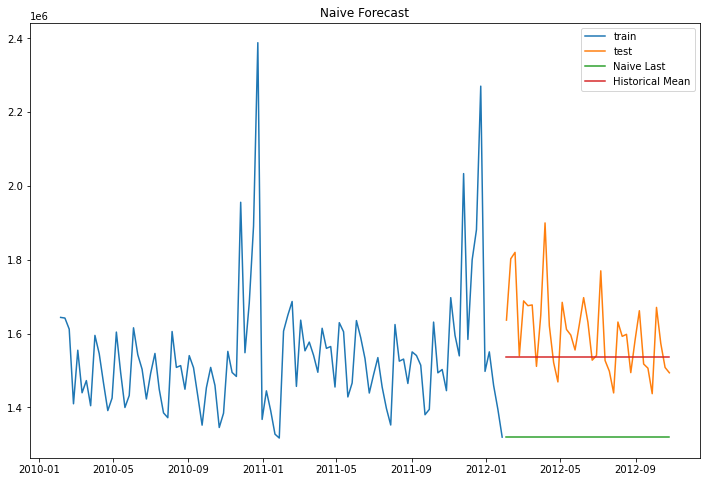

In [33]:
plt.figure(figsize=(12,8))

plt.plot(train['sales'], label = 'train')
plt.plot(test['sales'], label = 'test')
plt.plot(df_predictions['last'], label = 'Naive Last')
plt.plot(df_predictions['simple_mean'], label='Historical Mean')

plt.legend()
plt.title('Naive Forecast');

#### Evaluate

In [34]:
mean_squared_error(df_predictions['sales'], df_predictions['simple_mean'],squared=False)

122190.5821502407

## Model 3: Seasonality

Forecast = 52 observations prior if you have weekly sales data and the seasonal pattern repeats every 52 weeks.

In [35]:
df_predictions['seasonal'] = train['sales'].shift(52, freq = 'infer')

In [36]:
df_predictions.head()

,sales,last,simple_mean,seasonal
Date,,,,
2012-02-03,1636339.65,1319325.59,1.537735e+06,1606629.58
2012-02-10,1802477.43,1319325.59,1.537735e+06,1649614.93
2012-02-17,1819870.00,1319325.59,1.537735e+06,1686842.78
2012-02-24,1539387.83,1319325.59,1.537735e+06,1456800.28
2012-03-02,1688420.76,1319325.59,1.537735e+06,1636263.41


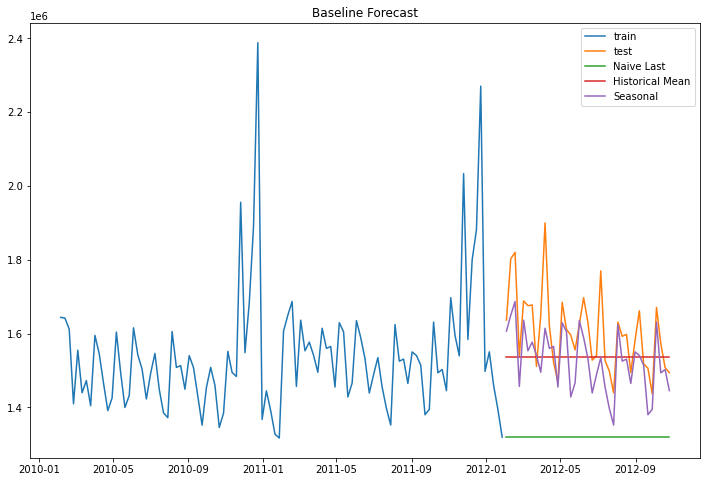

In [37]:
plt.figure(figsize=(12,8))

plt.plot(train['sales'], label = 'train')
plt.plot(test['sales'], label = 'test')
plt.plot(df_predictions['last'], label = 'Naive Last')
plt.plot(df_predictions['simple_mean'], label='Historical Mean')
plt.plot(df_predictions['seasonal'],label='Seasonal')

plt.legend()
plt.title('Baseline Forecast');

In [38]:
mean_squared_error(df_predictions['sales'], df_predictions['seasonal'],squared=False)

100227.53224396099

---
## Model 4: Simple Exponential Smoothing

Smoothing just means using a moving average. Read more on moving averages from Hyndman [here](https://robjhyndman.com/papers/movingaverage.pdf).

Simple exponential smoothing uses weighted averages where the weights decrease exponentially for older data points. 

$${\Large\hat y_{t+1} = \alpha y_t + \alpha (1-\alpha)y_{t-1} + \alpha(1-\alpha)^2 y_{t-2} + ...}$$

The one-step-ahead forecast for time `t+1` is a weighted average of all of the observations in the series (`y1,…,yt`). The rate at which the weights decrease is controlled by the parameter, `α` (which is between 0 and 1 with larger values of `α` meaning faster decay).

**Older values matter less.**

If alpha =.5: 

- What is the weight of the most recent observation (t)? 
- What is the weight of (t-1)?
- What is the weight of (t-2)?

#### Let's use statsmodels for more advanced time series models to make life easier.

In [39]:
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing

In [40]:
ses = SimpleExpSmoothing(train['sales'])

C:\Users\Sparrow\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


In [41]:
model = ses.fit(smoothing_level=0.5)

#### Summary info

In [42]:
model.summary()

Dep. Variable:,sales,No. Observations:,104
Model:,SimpleExpSmoothing,SSE,3058635205258.985
Optimized:,True,AIC,2510.878
Trend:,None,BIC,2516.167
Seasonal:,None,AICC,2511.282
Seasonal Periods:,None,Date:,"Tue, 29 Nov 2022"
Box-Cox:,False,Time:,10:54:47
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5000000,alpha,False
initial_level,1.6166e+06,l.0,True


#### The best thing about statsmodels is the summary. 

Here you get lots of info: AIC, BIC, AICC, etc. 🎉

The AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) above are measures of how well the model fits. Lower is better. They consider the complexity of the model - like adjusted R2.

#### Forecast with `.forecast`

Here you can just pass an integer for the number of forecasts. 

In [45]:
ses_forecast = model.forecast(len(test))

In [47]:
ses_forecast.head()

2012-02-03    1.398212e+06
2012-02-10    1.398212e+06
2012-02-17    1.398212e+06
2012-02-24    1.398212e+06
2012-03-02    1.398212e+06
Freq: W-FRI, dtype: float64

In [48]:
df_predictions['ses'] = ses_forecast

In [49]:
df_predictions.head(2)

,sales,last,simple_mean,seasonal,ses
Date,,,,,
2012-02-03,1636339.65,1319325.59,1.537735e+06,1606629.58,1.398212e+06
2012-02-10,1802477.43,1319325.59,1.537735e+06,1649614.93,1.398212e+06


#### Plot

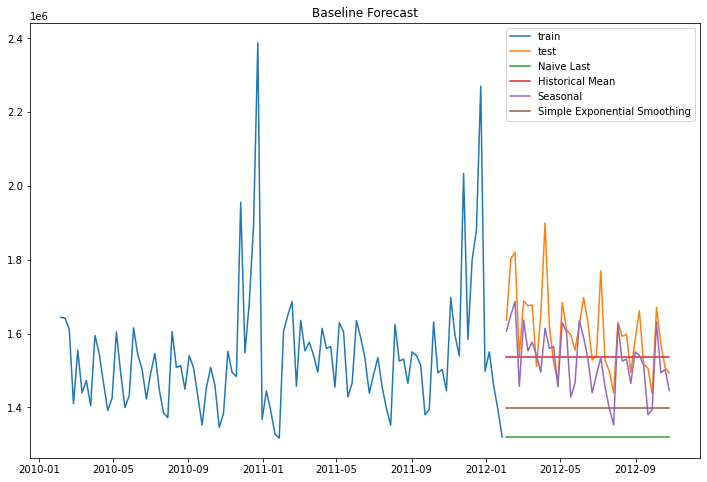

In [50]:
plt.figure(figsize=(12,8))

plt.plot(train['sales'], label = 'train')
plt.plot(test['sales'], label = 'test')
plt.plot(df_predictions['last'], label = 'Naive Last')
plt.plot(df_predictions['simple_mean'], label='Historical Mean')
plt.plot(df_predictions['seasonal'],label='Seasonal')
plt.plot(df_predictions['ses'],label = 'Simple Exponential Smoothing')

plt.legend()
plt.title('Baseline Forecast');

You can play with the smoothing level, but SES forecasts the same number every time, so this isn't going to be a winner.

---
## Model 5: Holt-Winters' (additive and multiplicative versions)

- Part of the exponential smoothing family of algorithms. 
- It's also called *Triple Exponential Smoothing*

Holt-Winters' can handle trend and seasonality. It weights recent values more than old ones. This is a very strong classical time series model. 🎉

#### Params to choose: 
- number of seasonal_periods
- seasonal period effects additive or multiplicative
- additive or multiplicative trend

In [53]:
hw = ExponentialSmoothing(
    train['sales'],
    seasonal_periods=52,
    trend='add',
    seasonal='mul',
).fit()

C:\Users\Sparrow\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [54]:
hw.summary()

Dep. Variable:,sales,No. Observations:,104
Model:,ExponentialSmoothing,SSE,216135960654.647
Optimized:,True,AIC,2343.297
Trend:,Additive,BIC,2491.383
Seasonal:,Multiplicative,AICC,2495.386
Seasonal Periods:,52,Date:,"Tue, 29 Nov 2022"
Box-Cox:,False,Time:,11:06:04
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0403571,alpha,True
smoothing_trend,0.0322857,beta,True


In [55]:
df_predictions['hw'] = hw.forecast(len(test))
df_predictions.head(3)

,sales,last,simple_mean,seasonal,ses,hw
Date,,,,,,
2012-02-03,1636339.65,1319325.59,1.537735e+06,1606629.58,1.398212e+06,1.666958e+06
2012-02-10,1802477.43,1319325.59,1.537735e+06,1649614.93,1.398212e+06,1.710615e+06
2012-02-17,1819870.00,1319325.59,1.537735e+06,1686842.78,1.398212e+06,1.747635e+06


#### Plot

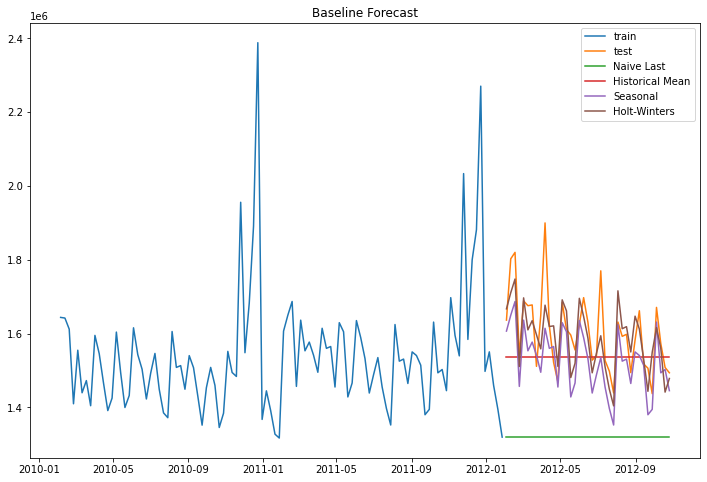

In [56]:
plt.figure(figsize=(12,8))

plt.plot(train['sales'], label = 'train')
plt.plot(test['sales'], label = 'test')
plt.plot(df_predictions['last'], label = 'Naive Last')
plt.plot(df_predictions['simple_mean'], label='Historical Mean')
plt.plot(df_predictions['seasonal'],label='Seasonal')
plt.plot(df_predictions['hw'], label = 'Holt-Winters')

plt.legend()
plt.title('Baseline Forecast');

#### Evaluate

In [57]:
mean_squared_error(df_predictions['sales'], df_predictions['hw'], squared=False)

72235.08180948308

## Why did Holt-Winters' work well?

A time series dataset can be decomposed into its trend, seasonality, and residual components.

Let's break down the components using statsmodels `seasonal_decompose` function. 

In [58]:
from statsmodels.tsa.seasonal import seasonal_decompose

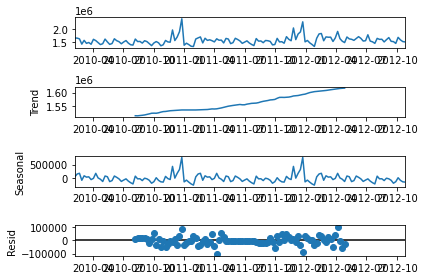

In [60]:
seasonal_decompose(store_1_sales,period=52).plot();

Holt-Winters' uses exponential smoothing and takes into account the trend and seasonality to forecast future sales. 

You have to choose the number of seasonal periods, and whether the trend and seasonal components are additive or multiplicative. 

---
## Seasonality

Two primary kinds of seasonality:

### Additive vs. Multiplicative Seasonality

Seasonality can present itself in two ways:

1. __Additive:__ the peaks and valleys keep the same magnitude over time.
2. __Multiplicative:__ the peaks and valleys change in magnitude over time.

You can plot the data over time to see which kind of seasonality effects the data show:

#### Additive Seasonality
<img src="assets/adding.png" width="300px">

#### Multiplicative Seasonality
<img src="assets/multi.png" width="300px">

Alternatively, GridSearch it - or use a function that GridSearchs for you! 😀


We'll see some ways to deal with the trend in the next lesson. For now, just know that Hyndman says don't use multiplicative for trend. 

The **Holt-Winters** method takes into account both trend and seasonality to forecast future sales. 

With this method, we will apply exponential smoothing to the seasonal components as well as the level and trend components. 

Here are the constituent parts of the additive model:

<h3><center>Level Equation</center></h3> $$L_t = \alpha (y_t - S_{t-s}) + (1 - \alpha)(L_{t-1} + b_{t-1})$$ 
<h3><center>Trend Equation</center></h3> $$b_t = \beta *(L_t - L_{t-1}) + (1 - \beta)b_{t-1}$$
<h3><center>Seasonality Equation</center></h3> $$S_t = \gamma(y_t-L_t)+(1-\gamma)S_{t-s}$$

Combine these into a single equation: 

<h3><center>Forecast Equation</center></h3> $${\Large F_{t+k} = L_t + kb_t+S_{t+k-s}}$$
<br>

(Where `α`, `β`, and `γ` are the smoothing parameters — each between 0 and 1 — and `s` is the length of the seasonal cycle.)

* **The trend equation captures the overall direction of sales.** 
* The level equation is a weighted average between the seasonally adjusted observation and the non-seasonal forecast for time `t`. 
* The seasonal equation is a weighted average between the current seasonal index and the seasonal index of the same season `s` time periods ago. 

---
#### Write out the train, test, and prediction DataFrames to pickle file format to use later

In [ ]:
# train.to_pickle('./train.pkl')
# test.to_pickle('./test.pkl')
# df_predictions.to_pickle('./df_predictions.pkl')

___

#### If my observations are by the minute and there is a big spike in users once per week, what number should I use for seasonality?

In [61]:
60 *24 *7

10080

---
## Exercises

#### Hyperparameter search to see if a different Holt Winter's model will perform better.

#### Pick a different store. Does the model perform similarly? 

Note: Pandas has exponential weighted functions, rolling functions, and expanding window transformations. Great for looking at historical data, but statsmodels is far better for making forecasts.


---
## Check out the great free ebook: ⭐️
[Forecasting: Principles and Practice by
Rob J Hyndman & George Athanasopoulos](https://otexts.com/fpp3/) to learn more about time series. Hyndman is also behind a lot of the time series code and strategy in an R package that Python packages use.

Jason Brownlee also has a lot of great information and Python code on time series forecasting at [Machine Learning Mastery](https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/).

## Summary
- **Always sort your time series data by date**
- **Make sure you aren't leaking information from the future into your training data**
- Make baseline models first
- Consider the tradeoffs between complexity and performance when choosing which model to use
- Holt-Winters' Exponential Smoothing is really powerful and doesn't have too many parameters to choose
- Seasonality is how many observations it takes for a pattern to repeat

### Check for understanding

- How can you keep from leaking test data into your training data?
- What does *trend* mean?
- If you have data by the hour and a cycle repeats once every day, what will the seasonality be?
